In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'


In [2]:
import numpy as np
import pandas as pd 
from fastai.vision.all import * 
from fastai.metrics import accuracy
from PIL import Image
from PIL import ImageFile 
import matplotlib.pyplot as plt 
import torch 
from torch import nn, optim
import torch.nn.functional as F
from tqdm import tqdm 
from IPython.display import clear_output 
import warnings 
from pathlib import Path
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import optuna
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch.cuda.amp import GradScaler, autocast
warnings.filterwarnings("ignore")

c:\Users\Acer\.conda\envs\llama3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
data_path = Path(r'C:\Users\Acer\Desktop\test\Mushrooms')

In [5]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [6]:
def print_history(history, title):
    plt.figure(figsize=(7, 4))
    plt.plot(history)
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

In [ ]:
class MushroomDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.images = []
        self.labels = []
        
        for folder_name in os.listdir(data_path):
            folder_path = os.path.join(data_path, folder_name)
            if not os.path.isdir(folder_path):
                continue
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                self.images.append(img_path)
                self.labels.append(folder_name)
        
        self.label_encoder = LabelEncoder()
        self.encoded_labels = self.label_encoder.fit_transform(self.labels)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.encoded_labels[idx]
        try:
            img = Image.open(img_path).convert('RGB').resize((96, 96))
            if self.transform:
                img = self.transform(img)
        except:
            print(f"Error loading image {img_path}, returning white image.")
            img = np.ones((96, 96, 3), dtype=np.uint8) * 255 
        return img, label


In [8]:
np.random.seed(3)

In [9]:
# Применяем трансформации
img_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.13, 0.31, 0.31], std=[0.5, 0.5, 0.5])
])

# Создание датасета и DataLoader
dataset = MushroomDataset(data_path, transform=img_transforms)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
del dataset
train_dataloader = DataLoader(train_dataset, 32, shuffle=False)
test_dataloader = DataLoader(test_dataset, 32, shuffle=False)


In [10]:
print(len(train_dataset))
print(len(test_dataset))

5371
1343


In [11]:
class_names = ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.62..1.7321569].


Batch shape is torch.Size([3, 96, 96])


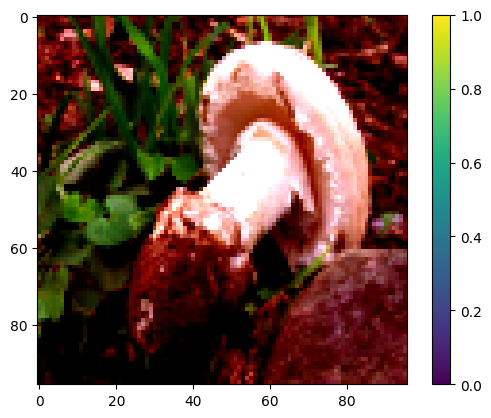

In [12]:
images_data, label_data = next(iter(train_dataloader))
print('Batch shape is', images_data[0].shape)
plt.figure()
plt.imshow(images_data[0].permute(1, 2, 0).numpy())
plt.colorbar()
plt.show()


In [13]:
print('Original shape is:', images_data[0].shape)  # [C, H, W]


Original shape is: torch.Size([3, 96, 96])


In [14]:
def build_alexnet():
    def init_weights(m):
        if isinstance(m, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        if isinstance(m, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
        
    net = torch.nn.Sequential(
        # Input: 96x96x3 (RGB Image)
        torch.nn.Conv2d(3, 96, 11, stride=4, padding=2),  # out: 24x24x96
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=3, stride=2),  # out: 11x11x96
        
        torch.nn.Conv2d(96, 256, 5, padding=2),  # out: 11x11x256
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=3, stride=2),  # out: 5x5x256
        
        torch.nn.Conv2d(256, 384, 3, padding=1),  # out: 5x5x384
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(384, 384, 3, padding=1),  # out: 5x5x384
        torch.nn.ReLU(),
        
        torch.nn.Conv2d(384, 256, 3, padding=1),  # out: 5x5x256
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=3, stride=2),  # out: 2x2x256
        
        torch.nn.Flatten(),
        
        torch.nn.Linear(2*2*256, 4096),  # fully connected layer 1
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),
        
        torch.nn.Linear(4096, 4096),  # fully connected layer 2
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),
        
        torch.nn.Linear(4096, 10)  # fully connected layer 3 (output layer, 10 classes)
    )

    net.apply(init_weights)
    return net

In [15]:
net = build_alexnet()
net.to(device)
print(net)
del train_dataloader

Sequential(
  (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=1024, out_features=4096, bias=True)
  (15): ReLU()
  (16): Dropout(p=0.5, inplace=False)
  (17): Linear(in_features=4096, out_features=4096, bias=True)
  (18): ReLU()
  (19): Dropout(p=0.5, inplace=False)
  (20): Linear(in_featu

In [16]:
def train(net, train_loader, device, num_epochs, learning_rate):
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    loss_function = torch.nn.CrossEntropyLoss()
    acc_history = []
    
    scaler = GradScaler()  # Для Mixed Precision Training

    with tqdm(total=len(train_loader)*num_epochs, position=0, leave=True) as pbar:

        for epoch in range(num_epochs):
            running_loss = 0.0
            correct = 0
            total = 0 
            
            for batch_num, (inputs, labels) in enumerate(train_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                # Mixed Precision Training
                with autocast(): 
                    outputs = net(inputs)
                    loss = loss_function(outputs, labels)

                # Backpropagation                
                scaler.scale(loss).backward()

                scaler.step(optimizer)
                scaler.update()

                running_loss += loss.item()

                # Calculate batch Accuracy
                _, predicted = outputs.max(1)
                batch_total = labels.size(0)
                batch_correct = predicted.eq(labels).sum().item()
                batch_acc = batch_correct/batch_total
                
                pbar.set_description("Epoch: %d, Batch: %2d, Loss: %.2f, Acc: %.2f" % (epoch, batch_num, running_loss, batch_acc))
                pbar.update()

                total += batch_total
                correct += batch_correct

            # Print the evaluation metric and reset it for the next epoch
            acc = correct/total 
            acc_history.append(acc)

        pbar.close()

    return acc_history

In [17]:

EPOCHS = 15
BATCH_SIZE = 256
LR = 0.0023907002927538432
train_dataloader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle = True,
    pin_memory=True,
)
hist_net = train(net, train_dataloader, device, EPOCHS, LR)

Epoch: 5, Batch: 13, Loss: 28.49, Acc: 0.19:  38%|███▊      | 119/315 [05:28<09:01,  2.76s/it]


KeyboardInterrupt: 

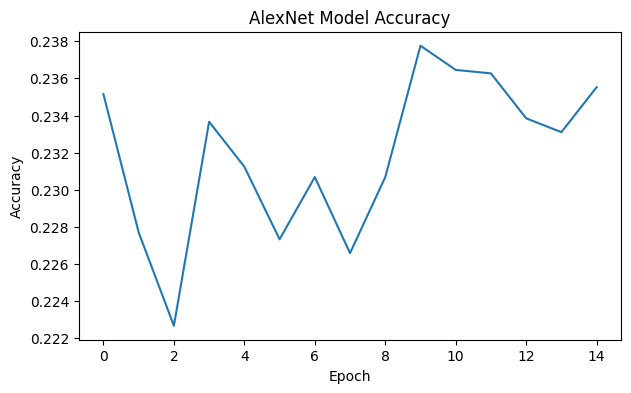

In [ ]:
print_history(hist_net, "AlexNet Model Accuracy")

In [ ]:
hist_net

[0.21262334760752188,
 0.2269595978402532,
 0.24353006888847514,
 0.27145782908210764,
 0.3012474399553156,
 0.32545149878979707,
 0.35505492459504745,
 0.3820517594488922,
 0.40048408117668965,
 0.43381120834109105,
 0.44982312418544035,
 0.4889219884565258,
 0.5205734500093092,
 0.5687953826103147,
 0.5957922174641593,
 0.6317259355799665,
 0.6687767641035189,
 0.7000558555203873,
 0.7227704338112083,
 0.7544218953639918,
 0.7570284863153975,
 0.7966859057903556,
 0.8195866691491343,
 0.8253584062558182,
 0.8728355985849935,
 0.8778625954198473,
 0.9016942841184137,
 0.9117482777881214,
 0.9128653881958667,
 0.9258983429528952,
 0.9279463787004282]

In [ ]:
def evaluate_acc(net, test_loader, device):
    total = 0
    correct = 0
    all_labels = []
    all_preds = []
    
    for _, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.permute(0, 3, 1, 2).to(device)
        labels = labels.to(device)
        
        outputs = net(inputs)        
        _, predicted = outputs.max(1)
        
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
    
    acc = correct / total
    
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    return acc

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

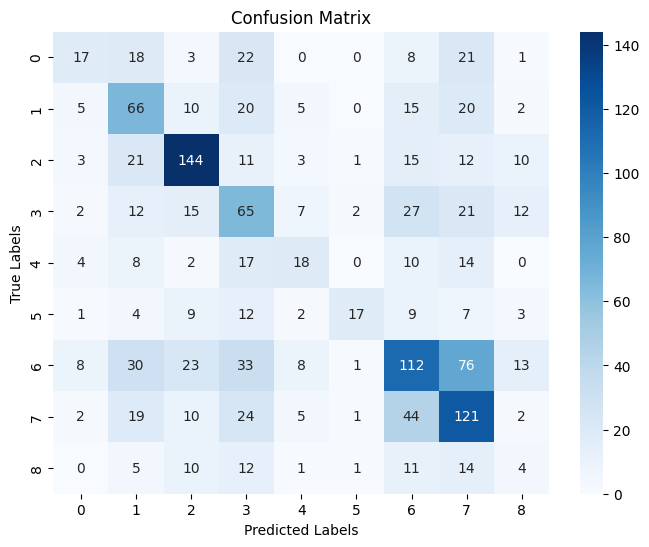

Test Accuracy (LeNet): 42.00%


In [ ]:
lenet_acc = evaluate_acc(net, test_dataloader, device)

print('Test Accuracy (LeNet): {:.2%}'.format(lenet_acc))

### HYPERPARAMS

In [ ]:
def objective(trial):
    BATCH_SIZE = trial.suggest_categorical("batch_size", [16, 32, 64])
    EPOCHS = trial.suggest_int("epochs", 30, 50)
    LR = trial.suggest_loguniform("lr", 0.001, 0.005)

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
    model = net.to(device)
    hist_net = train(model, train_dataloader, device, EPOCHS, LR)

    val_accuracy = hist_net[-1]
    
    return 1.0 - val_accuracy

#study = optuna.create_study(direction="maximize")
#study.optimize(objective, n_trials=3)
#
#print("Best hyperparameters:", study.best_params)
#Best hyperparameters: {'batch_size': 16, 'epochs': 31, 'lr': 0.0023907002927538432}

In [ ]:
def show_random(net, dataloader, train_image_no):
    def get_prediction(net, input):
        input = input.to(device)
        outputs = net(input)        
        _, predicted = outputs.max(1)
        return predicted

    images_data, original_label = next(iter(dataloader))
    images_data = images_data[train_image_no]
    original_label = original_label[train_image_no]

    print("images_data shape:", images_data.shape)

    if len(images_data.shape) == 3:  # if no batch dimension, add it
        images_data = images_data.unsqueeze(0) 
    
    images_data = images_data.permute(0, 3, 1, 2)

    predicted_label = get_prediction(net, images_data)
    print('original_label ', original_label) 
    print('predicted_label ', predicted_label)
    c = 'green' if original_label == predicted_label[0] else 'red'

    plt.figure()
    plt.imshow(images_data[0].cpu().numpy().transpose(1, 2, 0))
    plt.colorbar()
    plt.xlabel(class_names[predicted_label], color=c)
    plt.show()


images_data shape: torch.Size([96, 96, 3])
original_label  tensor(5)
predicted_label  tensor([6], device='cuda:0')


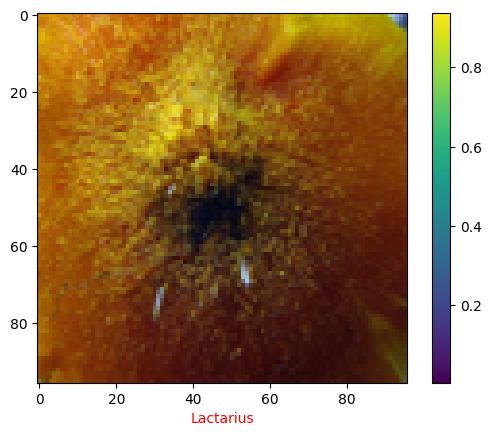

In [ ]:
#nn
show_random(net, test_dataloader, random.randint(0,10))